# Intro to Gaussian Mixtures

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display, Image

# import standard libs
from pathlib import Path
import sys
import time
from copy import copy

script_dir =  "../scripts"
sys.path.append(script_dir)

# import python scientific stack
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
import seaborn as sns
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf

# import util libs
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
from utils import cprint

RANDOM_STATE = 824

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn

Last updated: 2023-08-03T22:02:03.364801+02:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit


pandas           : 1.5.3
pandas_datareader: 0.10.0
numpy            : 1.23.5
sklearn          : 1.2.2
statsmodels      : 0.14.0
scipy            : 1.10.1
matplotlib       : 3.7.1
seaborn          : 0.12.2



In [2]:
sns_params = {
    "axes.grid": True,
    "ytick.left": True,
    "xtick.bottom": True,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 11,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "DejaVu Sans Mono",  # "Ubuntu Mono",
}

sns.set(context="poster", style="ticks", rc=sns_params)
savefig_kwds = dict(dpi=90, bbox_inches="tight",format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))

## Gaussian Mixture Models (GMM) Intuition


Our biggest pain point results from the idea that asset returns are comprised of multiple distributions. Time varying means, and volatilities can be considered as coming from different distributions, regimes, or states _(moving forward I will use those terms interchangeably)_. Each regime has its own parameters. 

For example consider two regimes with the following characteristics.
    
    1. Stable, low volatility
    2. Risky, high(er) volatility

We can make an assumption that every data point from our return series has come from either the _stable_ or _risky_ regime. If we can classify each data point correctly then we can use the current regime's parameters as the input to our prediction for the next period. _As we know, the best estimate for an unpredictable future state is the current state._

That sounds good however we still have some challenges. 

1. We do not know the parameters, ($\mu, \sigma$), for the two regimes. 
2. We do not know which datapoint came from which regime.

On first pass this problem seems intractable. 

Fortunately for us, some smart people devised a solution. 

> __Expectation-maximization algorithm (EM, E-M, em, etc.)__

Most introductory texts on this subject explain the topic using heavy maths first, somewhat obscuring the concept and leaving one feeling like its _magic_ and moving on. I hope to avoid that outcome in this brief intro and make it more intuitive. 

### Why do we need Expectation-Maximization, why bother to understand it?

The EM algorithm and derivations thereof underpin many unsupervised learning methods including mixture modeling. It is useful in many real world applications where:

    - Data is corrupted.
    - Data is missing.
    - We do not know the parameters of data generating process (aka model, distribution).
    - We do not know which data generating process generated which data point.
 

### Expectation-Maximization Walkthrough Example

Let's continue with our example of an asset return series being generated by a combination of 2 Gaussian distributions. To start we let's say we have some number of years worth of return data. 

- To start the algorithm all we have to do is guess at the parameters even though we know __those guesses are likely incorrect__.

We will assume:
- for example we can assume the stable regime has returns with mean `2.5%` and sigma `9%`
- the risky regime has `-1.0%` returns and `25%` volatility. 
- each regime occurs with equal probability

The next step is to assume those incorrect guesses are correct and proceed to assign responsiblities _(aka probabilities or weights)_ to each data point. 

- So for example assume the first data point we have is a return of `1.3%`. 
- We must compute the probability that the `stable` regime, a Gaussian distribution with mean `2.5%` and std of `9%` generated that return. 
- We do that for all the returns on the first pass, again reusing those initial incorrect guesses about the means and volatilties. 
- We then compute the probability that the `risky` regime generated those data points. 

Next we sum those probabilities, normalize them, and use those assignments to reestimate the means and volatilities of the regimes. Rinse and repeat. 

What's remarkable about this iterative process is that we are guaranteed to improve our estimate at each iteration. 

_Note: this algorithm **does not** guarantee a global solution, but rather a local one. In practice the algorithm is started with multiple random parameter initializations in order to recover the best estimates of the true parameters._












_end_

For this example, we will assume the x values are drawn from Gaussian distributions. 

Here are the two basic formulas that we will use to implement the algorithm. These are repeated until convergence or a maximum number of iterations are completed. 

#### The expectation step:

We calculate the expected values $E(z_{ij})$, which is the probability that $x_i$ was drawn from the $jth$ distribution.
    
$$E(z_{ij}) = \frac{p(x = x_i|\mu = \mu_j)}{\sum_{n=1}^2 p(x = x_i|\mu = \mu_j)}$$


$$= \frac{ e^{-\frac{1}{2\sigma^2}(x_i - \mu_j)^2} }
{ \sum_{n=1}^2e^{-\frac{1}{2\sigma^2}(x_i - \mu_n)^2} }$$

The formula simply states that the expected value for $z_{ij}$ is the probability $x_i$ given $\mu_j$ divided by the sum of the probabilities that $x_i$ belonged to each $\mu$

#### The maximization step:

After calculating all $E(z_{ij})$ values we can calculate (update) new $\mu$ values. 

$$ \mu_j = \frac {\sum_{i=1}^mE(z_{ij})x_i} {\sum_{i=1}^mE(z_{ij})}$$

This formula generates the maximum likelihood estimate. 

By repeating the E-step and M-step we are guaranteed to find a local maximum giving us a maximum likelihood estimation of our hypothesis. 

#### Create Synthetic Return Data

For this example let's assume we know the true means, sigmas, and prior probabilities for each of the distributions, and we want to test the ability of the EM algorithm to recover this information from noisy data.

To set up this brief demonstration below we define the number of samples `n`, the true means, and sigmas, as well as the true prior probability of each regime. 

Then we'll create a synthetic return series comprised of the two gaussians using our true parameters. 


In [3]:
def mix_data(true_mus, true_sigmas, true_probs):
    """
    create mixed dataset using binomial and random normal distributions
    
    Params
    ------
    true_mus: dict
        contains 'stable' and 'risky' regime means
    true_sigmas: dict
        contains 'stable' and 'risky' regime stds
    true_probs: dict
        contains 'stable' and 'risky' regime probabilities
    n: int
    
    Returns
    -------
    fake_returns: pd.Series
    """
    # fake dates to make it look real
    fake_dates = pd.period_range(start="2002", end="2023", freq="M")
    n = len(fake_dates)
    np.random.seed(0)
    # randomly sample from binomial to select distr.
    zs = np.random.binomial(1, true_probs["risky"], n)
    regime_map = {0: "stable", 1: "risky"}

    xs = []
    for z in zs:
        # sample from normal distr. and associated parameters according to z
        xs.append(np.random.normal(true_mus[regime_map[z]], true_sigmas[regime_map[z]]))

    # fake dates to make it look real
    #fake_dates = pd.period_range(start="2003", periods=n, freq="M")
    fake_returns = pd.Series(xs, index=fake_dates)
    return fake_returns

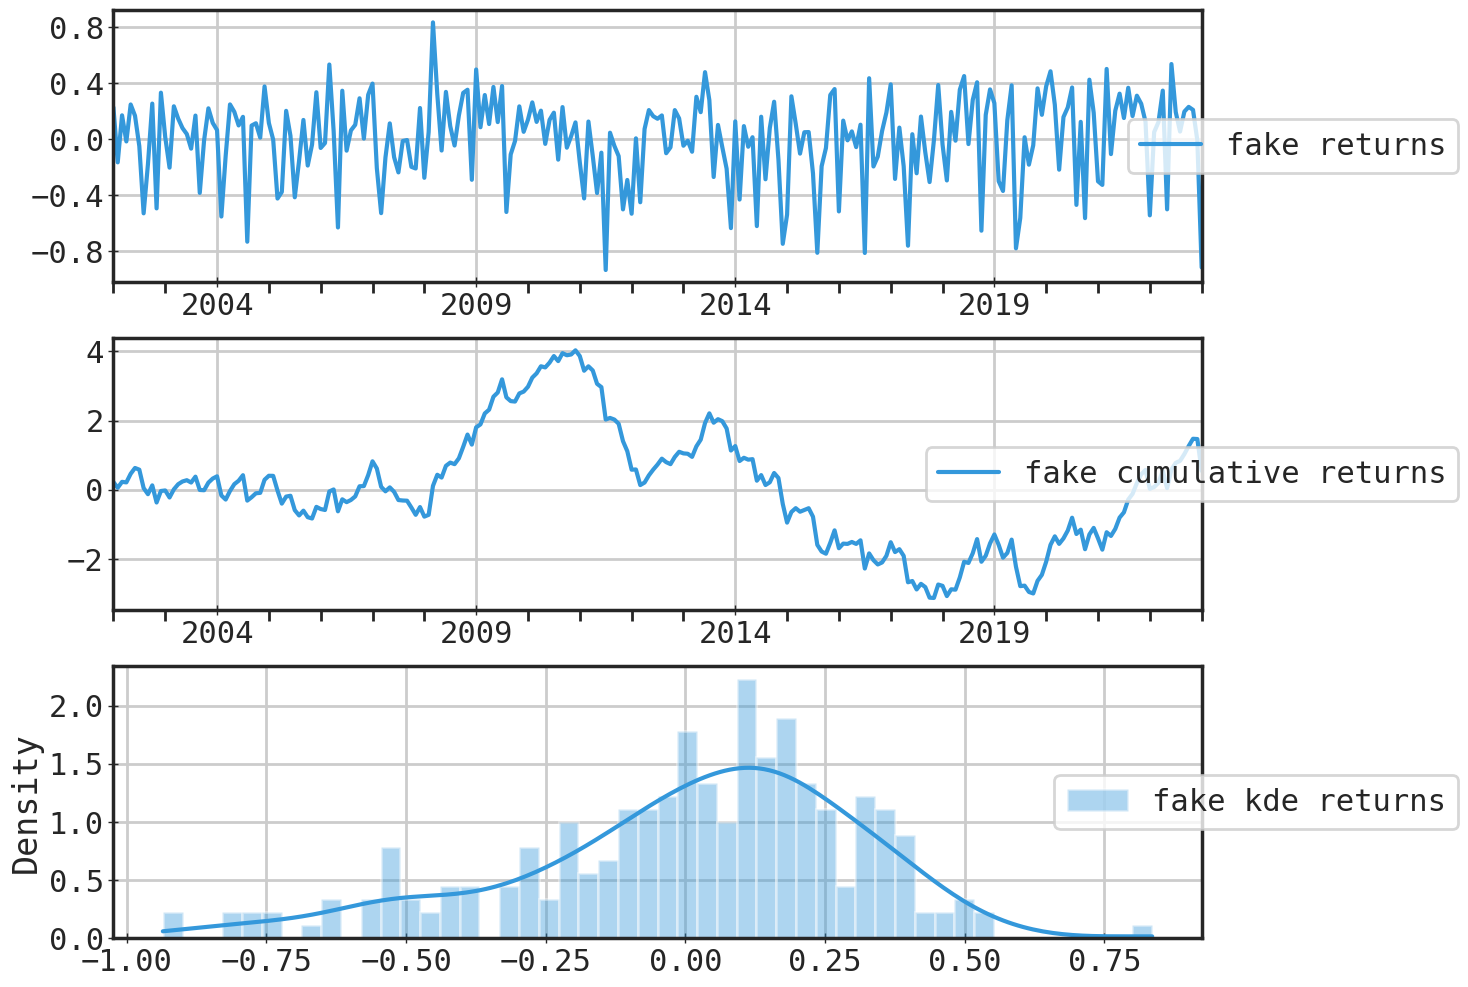

In [4]:
regime_labels = ["stable", "risky"]
true_mus = dict.fromkeys(regime_labels)
true_sigmas = dict.fromkeys(regime_labels)
true_probs = dict.fromkeys(regime_labels)

# ---------------------------------------------------------------------------
# true values
# ---------------------------------------------------------------------------

true_mus["stable"], true_sigmas["stable"] = 0.15, 0.20
true_mus["risky"], true_sigmas["risky"] = -0.25, 0.35

true_probs["stable"] = 0.65
true_probs["risky"] = 1 - true_probs["stable"]

# ---------------------------------------------------------------------------
# mixed up data
# ---------------------------------------------------------------------------

mixed = mix_data(true_mus, true_sigmas, true_probs)

# ---------------------------------------------------------------------------
# plot mixed up data
# ---------------------------------------------------------------------------

fig, axs = plt.subplots(nrows=3, figsize=(15, 10))

mixed.plot(ax=axs[0], label="fake returns")
mixed.cumsum().plot(ax=axs[1], label="fake cumulative returns")
sns.distplot(mixed, ax=axs[2], kde_kws=dict(cut=0), bins=50, label="fake kde returns")
for ax in axs:
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    ax.tick_params("both", direction="inout", length=7, width=1, which="major")
    ax.legend(loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.tight_layout()

In [5]:
mixed

2002-01    0.2285
2002-02   -0.1654
2002-03    0.1708
2002-04   -0.0159
2002-05    0.2486
            ...  
2022-09    0.1977
2022-10    0.2311
2022-11    0.2099
2022-12   -0.0081
2023-01   -0.9170
Freq: M, Length: 253, dtype: float64

#### Create Expectation and Maximization Functions

In [6]:
def weight_of_regime(regime_ll, total_ll):
    """
    Compute the weights of the regime using the likelihood
    computed using the stats.norm.pdf function
    
    These weights are used to rescale the data and restimate the parameters
    of the distributions. Those parameters are the mean and std.
    
    Params
    ------
    regime_ll: array-like
        contains the probability that each datapoint was generated by the 
        gaussian distribution with our parameter guesses
    total_ll: array-like
        sum of the likelihoods of both regimes
        
    Returns
    -------
    array-like
        scaled probability of regime weights for each datapoint
    """
    return regime_ll / total_ll


def estimate_mean(data, weight):
    """
    Re-estimate/update the parameter mean.
    
    We use the computed regime weight to rescale the data in our update of 
    the estimate of the mean
    
    Params
    ------
    data: array-like
    weight: array-like
    
    Returns
    -------
    scalar float
        updated estimate of the distribution's mean
    """
    return np.sum(data * weight) / np.sum(weight)


def estimate_std(data, weight, mean):
    """
    Re-estimate/update the parameter std
    
    We use the updated mean, and the computed regime weights to update
    our estimate of the distribution standard deviation
    
    Params
    ------
    data: array-like
    weight: array-like
    mean: scalar float
    
    Returns
    -------
    scalar float
        updated esimate of the distribution's std
    """
    variance = np.sum(weight * (data - mean) ** 2) / np.sum(weight)
    return np.sqrt(variance)

#### Initialize our parameter estimates

And plot kde estimate of our guess

In [7]:
def plot_estimates(
    both_regimes,
    stable_mean_est,
    risky_mean_est,
    stable_std_est,
    risky_std_est,
    alpha=1,
):
    """
    Plot parameter estimates of the guassian distributions
        code adapted from: https://github.com/ajcr/em-explanation/blob/master/em-notebook-2.ipynb
    """
    # set figure size and plot the purple dots
    plt.rcParams["figure.figsize"] = (15, 5)
    plt.plot(
        both_regimes, np.zeros_like(both_regimes), ".", color="purple", markersize=10
    )

    # compute the size of the x axis
    lo = np.floor(both_regimes.min()) - 0.25
    hi = np.ceil(both_regimes.max()) + 0.25
    x = np.linspace(lo, hi, 500)

    # plot the bell curves
    plt.plot(
        x, stats.norm(stable_mean_est, stable_std_est).pdf(x), color="b", alpha=alpha
    )
    plt.plot(
        x, stats.norm(risky_mean_est, risky_std_est).pdf(x), color="r", alpha=alpha
    )

    # vertical dotted lines for the mean of each colour - find the height
    # first (i.e. the probability of the mean of the colour group)
    b_height = stats.norm(stable_mean_est, stable_std_est).pdf(stable_mean_est)
    r_height = stats.norm(risky_mean_est, risky_std_est).pdf(risky_mean_est)

    plt.vlines(stable_mean_est, 0, b_height, "b", "--", alpha=alpha)
    plt.vlines(risky_mean_est, 0, r_height, "r", "--", alpha=alpha)


#### Initialize our guesses

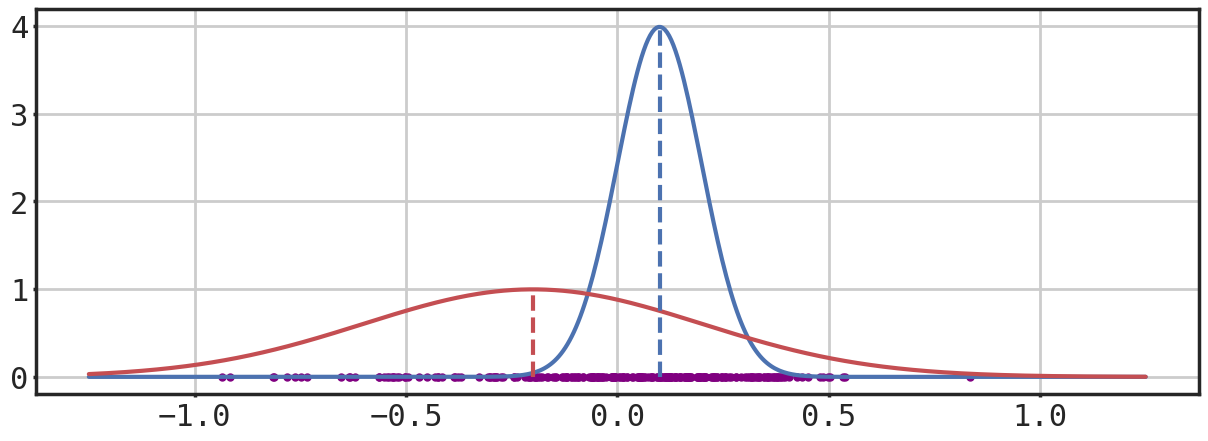

In [8]:
# ---------------------------------------------------------------------------
# initial guesses
# ---------------------------------------------------------------------------
regime_labels = ["stable", "risky"]

mu_est = dict.fromkeys(regime_labels)
sigma_est = dict.fromkeys(regime_labels)

# guesses at starting mean and std
mu_est["stable"], sigma_est["stable"] = 0.10, 0.10
mu_est["risky"], sigma_est["risky"] = -0.2, 0.4

plot_estimates(
    mixed, mu_est["stable"], mu_est["risky"], sigma_est["stable"], sigma_est["risky"]
)

#### Code EM demo function

In [9]:
def em_custom(
    both_regimes, mus, sigmas, true_mus, true_sigs, true_probs, tol=0.01, max_iter=100
):
    """
    demo EM algorithm using aforementioned functions
    """

    ms = copy(mus)
    sigs = copy(sigmas)
    stable_wts = 0.5
    risky_wts = 0.5
    alphas = np.linspace(0.2, 1, max_iter)

    lls = list()
    ll_old = 0
    for i in range(max_iter):
        ll_new = 0

        # E-Step
        ll_stable = (
            stats.norm(ms["stable"], sigs["stable"]).pdf(both_regimes) * stable_wts
        )
        ll_risky = stats.norm(ms["risky"], sigs["risky"]).pdf(both_regimes) * risky_wts

        stable_wts = weight_of_regime(ll_stable, ll_stable + ll_risky)
        risky_wts = weight_of_regime(ll_risky, ll_stable + ll_risky)

        ll_new += np.log(ll_stable + ll_risky).sum()
        lls.append(ll_new)

        # M-Step

        # update means
        ms["stable"] = estimate_mean(both_regimes, stable_wts)
        ms["risky"] = estimate_mean(both_regimes, risky_wts)

        # update sigs
        sigs["stable"] = estimate_std(both_regimes, stable_wts, ms["stable"])
        sigs["risky"] = estimate_std(both_regimes, risky_wts, ms["risky"])

        plot_estimates(
            both_regimes,
            ms["stable"],
            ms["risky"],
            sigs["stable"],
            sigs["risky"],
            alpha=alphas[i],
        )

        regime_map = {0: "stable", 1: "risky"}
        total_wts = np.sum(stable_wts) + np.sum(risky_wts)
        iter_data = pd.DataFrame(
            np.vstack(
                [
                    list(ms.values()),
                    list(sigs.values()),
                    [np.sum(stable_wts) / total_wts, np.sum(risky_wts) / total_wts],
                    list(true_mus.values()),
                    list(true_sigs.values()),
                    list(true_probs.values()),
                ]
            ),
            columns=["stable", "risky"],
            index=[
                "means",
                "sigs",
                "weights",
                "true_means",
                "true_sigs",
                "true_weights",
            ],
        ).round(3)

        if np.abs(ll_new - ll_old) < tol:
            print()
            print("-" * 77)
            print(f"convergence achieved at iteration: {i}")
            print(f"ll new: {ll_new:.3f}")
            display(iter_data.T)
            break
        ll_old = ll_new

        if i % 10 == 0:
            print()
            print("-" * 77)
            print(f"iteration: {i}")
            print(f"ll new: {ll_new:.3f}")
            display(iter_data.T)
    return lls

#### Run Expectation-Maximization Algorithm


-----------------------------------------------------------------------------
iteration: 0
ll new: -64.343


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1150,0.1210,0.4600,0.1500,0.2000,0.6500
risky,-0.0940,0.3730,0.5400,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 10
ll new: 58.691


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1320,0.1060,0.5340,0.1500,0.2000,0.6500
risky,-0.1470,0.3800,0.4660,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 20
ll new: 60.174


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1390,0.1040,0.5260,0.1500,0.2000,0.6500
risky,-0.1500,0.3730,0.4740,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 30
ll new: 60.970


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1440,0.1040,0.5220,0.1500,0.2000,0.6500
risky,-0.1530,0.3690,0.4780,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 40
ll new: 61.709


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1490,0.1040,0.5220,0.1500,0.2000,0.6500
risky,-0.1580,0.3640,0.4780,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 50
ll new: 62.526


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1530,0.1050,0.5250,0.1500,0.2000,0.6500
risky,-0.1640,0.3600,0.4750,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 60
ll new: 62.919


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1550,0.1060,0.5270,0.1500,0.2000,0.6500
risky,-0.1680,0.3580,0.4730,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 70
ll new: 63.339


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1570,0.1070,0.5290,0.1500,0.2000,0.6500
risky,-0.1710,0.3560,0.4710,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 80
ll new: 63.976


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1590,0.1080,0.5330,0.1500,0.2000,0.6500
risky,-0.1770,0.3530,0.4670,-0.2500,0.3500,0.3500



-----------------------------------------------------------------------------
iteration: 90
ll new: 64.447


,means,sigs,weights,true_means,true_sigs,true_weights
stable,0.1610,0.1090,0.5370,0.1500,0.2000,0.6500
risky,-0.1810,0.3510,0.4630,-0.2500,0.3500,0.3500


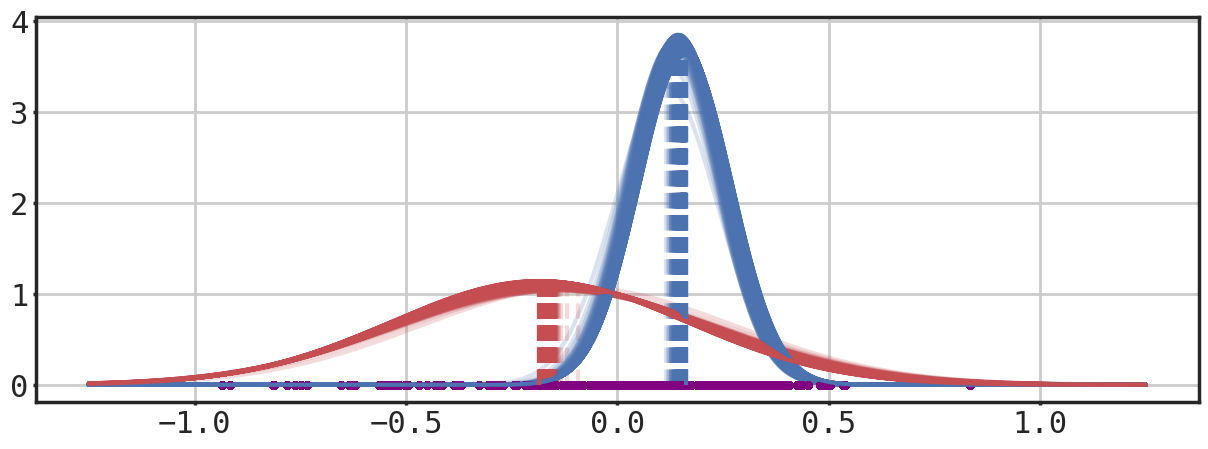

In [10]:
ll = em_custom(mixed, mu_est, sigma_est, true_mus, true_sigmas, true_probs, tol=1e-9)

Text(0.5, 1.0, 'Maximizing Log Likelihood')

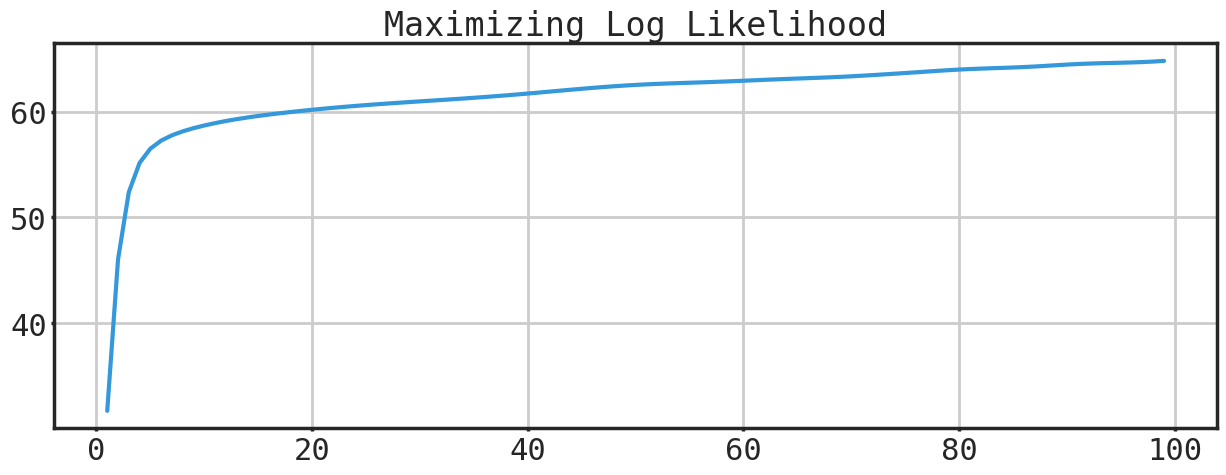

In [11]:
pd.Series(ll)[1:].dropna().plot()
plt.title("Maximizing Log Likelihood")

## Fitting Mixture Models Using Real Data

#### Import return data

In [12]:
load_rs = '../data/etf_returns_2007-04-11-2023-07-31.csv'

rs = (pd.read_csv(load_rs, index_col=[0])) 
rs.index = pd.DatetimeIndex(rs.index) 
rs = rs.assign(year=lambda df: df.index.year)

rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4105 entries, 2007-04-11 00:00:00+00:00 to 2023-07-31 00:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4105 non-null   float64
 1   QQQ     4105 non-null   float64
 2   DIA     4105 non-null   float64
 3   TLT     4105 non-null   float64
 4   GLD     4105 non-null   float64
 5   EFA     4105 non-null   float64
 6   EEM     4105 non-null   float64
 7   BND     4105 non-null   float64
 8   VNQ     4105 non-null   float64
 9   year    4105 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 352.8 KB


In [13]:
sym = "SPY"
df = rs.loc["2008":].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3921 entries, 2008-01-02 00:00:00+00:00 to 2023-07-31 00:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     3921 non-null   float64
 1   QQQ     3921 non-null   float64
 2   DIA     3921 non-null   float64
 3   TLT     3921 non-null   float64
 4   GLD     3921 non-null   float64
 5   EFA     3921 non-null   float64
 6   EEM     3921 non-null   float64
 7   BND     3921 non-null   float64
 8   VNQ     3921 non-null   float64
 9   year    3921 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 337.0 KB


### Demo scikit-learn function

Continuing with our example, using SPY returns, let's use sklearn to fit a GMM model. First we will fit one using a single component. This is equivalent to fitting a single normal distribution to the set of returns.

In [14]:
def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(
        n_components=n_components,
        max_iter=max_iter,
        n_init=100,
        random_state=RANDOM_STATE,
    )

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm


def print_gmm_results(gmm, X):
    print("-" * 25)
    print(f"means: {gmm.means_.ravel()}")
    print("-" * 25)
    print(f"covars: {gmm.covariances_.ravel()}")
    print("-" * 25)
    print(f"sqrt covar: {np.sqrt(gmm.covariances_.ravel())}")
    print("-" * 25)
    print(f"aic: {gmm.aic(X):.5f}")
    print(f"bic: {gmm.bic(X):.5f}")
    print("-" * 25)

In [15]:
s = df[sym].copy()
max_iter = 150
_X = s.values.reshape(-1, 1)

gmm1 = make_gmm(1, max_iter)
gmm1.fit(_X)

preds = gmm1.predict(_X)

print_gmm_results(gmm1, _X)
print(f"data derived mean: {s.mean():.7f}")
print(f"data derived std: {s.std():.7f}")

-------------------------
means: [0.00036829]
-------------------------
covars: [0.00016864]
-------------------------
sqrt covar: [0.01298634]
-------------------------
aic: -22956.46364
bic: -22943.91544
-------------------------
data derived mean: 0.0003683
data derived std: 0.0129494


### How to Choose the Right Number of Components?

#### Comparing AIC and BIC of Different numbers of Component Mixtures

Note that the mean and standard deviation is the same as computed in the previous plot. Also note the `aic` and `bic` metrics. These reference the [`Akaike Information Criterion`](https://en.wikipedia.org/wiki/Akaike_information_criterion) and the [`Bayesian Information Criterion`](https://en.wikipedia.org/wiki/Bayesian_information_criterion). Without delving too heavily into the theoretical pros and cons of each, we can just say they are both methods which allow us to compare the relative suitability of different models. Generally speaking, when choosing among a set of models we want to choose the `aic` or `bic` with the smallest information criterion value.

> AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters. The penalty discourages overfitting, because increasing the number of parameters in the model almost always improves the goodness of the fit. - [wikipedia](https://en.wikipedia.org/wiki/Akaike_information_criterion)

The importance of the penalty component in each of the ICs cannot be overstated. As always, in the limit, you could technically fit a distribution, or add a parameter for _every_ datapoint, thereby grossly overfitting the model. 

Both metrics implement a penalty, however the `bic` penalizes additional parameters more heavily than the `aic` and will always result in a selecting fewer parameters than the `aic` would. Let's walkthrough a quick demo of this.

In [16]:
gmm2 = make_gmm(2, max_iter)
gmm2.fit(_X, s.index.values)

print_gmm_results(gmm2, _X)

-------------------------
means: [-0.00319786  0.00112762]
-------------------------
covars: [6.85053001e-04 5.54038643e-05]
-------------------------
sqrt covar: [0.02617352 0.00744338]
-------------------------
aic: -24315.70743
bic: -24284.33692
-------------------------


Above we fit a GMM model with `2` components. Notice that both the `aic` and `bic` are smaller than their single component counterparts. This implies that the model with `2` components is "better" than the one with a single component. What about more components? Let's try `15`. 

In [17]:
gmm15 = make_gmm(15, max_iter)
gmm15.fit(_X)

print_gmm_results(gmm15, _X)

-------------------------
means: [-0.00144831  0.01265921 -0.00683656 -0.02114158 -0.04579438  0.03307496
  0.00696692  0.1355773  -0.08313572 -0.03103664  0.00213654  0.02042545
  0.08971237 -0.01295966  0.05614036]
-------------------------
covars: [6.63805202e-06 9.97628854e-06 7.87576800e-06 1.46978616e-05
 3.69592619e-05 4.06237203e-05 7.81687976e-06 1.00000000e-06
 3.20164393e-04 1.65886969e-05 6.75523788e-06 1.70822804e-05
 2.26558460e-04 1.08280452e-05 5.72760556e-05]
-------------------------
sqrt covar: [0.00257644 0.00315853 0.00280638 0.00383378 0.00607941 0.00637367
 0.00279587 0.001      0.01789314 0.00407292 0.00259908 0.00413307
 0.01505186 0.0032906  0.00756809]
-------------------------
aic: -24443.11718
bic: -24167.05669
-------------------------


Now we see an example where the `aic` has improved by getting smaller but the `bic` is actually larger than the `2` component model. Here we see the result of the `bic` penalizing additional parameters more heavily. 

#### Choosing The Optimal Number of Components using AIC/BIC

Below we can see a comparison between the two metrics as we increase the number of components. We can also see that they choose different numbers of optimal components.

In [18]:
def make_ic_series(list_of_tups, name=None):
    """
    fn: convert list of tuples for information criterion (aic, bic) into series
    
    Params
    ------
    list_of_tups : list() of tuples()
        tuple[0] is n_component, tuple[1] is IC
    name : str(), name of IC
    
    Returns
    -------
    s : pd.Series()
        index is n_components, values are IC's
    """

    s = (
        pd.DataFrame(list_of_tups)
        .rename(columns={0: "n_components", 1: name})
        .set_index("n_components")
        .squeeze()
    )
    return s

Text(0.5, 0, 'n_components')

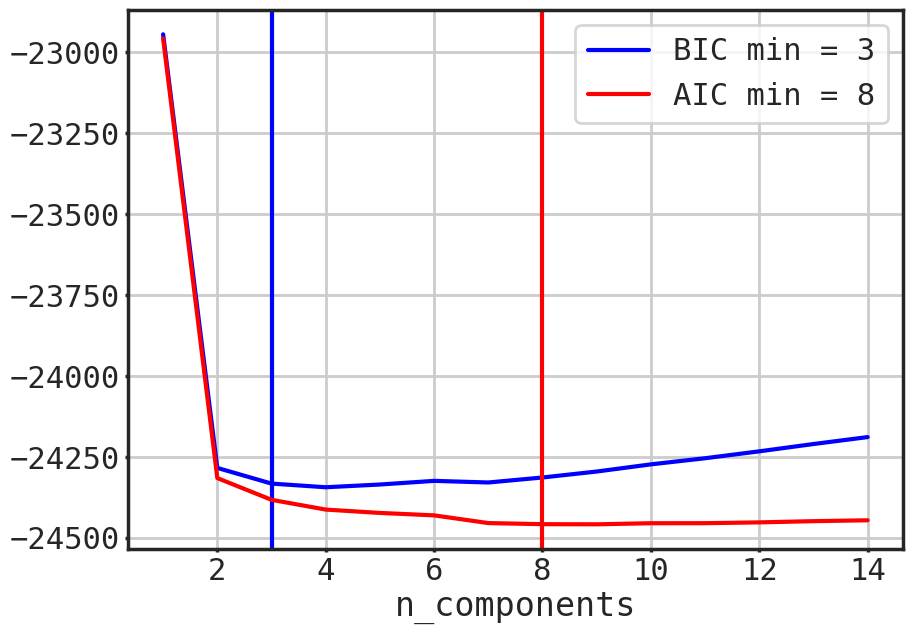

In [19]:
n_components = np.arange(1, 15)
aics = []
bics = []

for n in n_components:
    tmp_gmm = make_gmm(n, max_iter).fit(_X)
    aics.append((n, tmp_gmm.aic(_X)))
    bics.append((n, tmp_gmm.bic(_X)))

bics = make_ic_series(bics, "bic")
aics = make_ic_series(aics, "aic")

plt.figure(figsize=(10, 7))
plt.plot(n_components, bics.values, color="blue", label=f"BIC min = {np.argmin(bics)}")
plt.axvline(np.argmin(bics), color="blue")

plt.plot(n_components, aics.values, color="red", label=f"AIC min = {np.argmin(aics)}")
plt.axvline(np.argmin(aics), color="red")

plt.legend(loc="best")
plt.xlabel("n_components")

As shown above the `aic` selects `12` components as being the best model whereas the `bic` selects only `7`. For convenience we will use the `bic` recommendation for the remainder of the this notebook. One exercise I leave for the reader is to run the `aic`, `bic`, component analysis using different asset returns, and using different lookback periods. 

## Visualizing Regimes

Below is a demonstration of the how varied the components are across multiple lookback periods. Note that we choose only `2` components even though the `BIC` informed us that `7` was the "optimal" number. This is done for interpretability purposes. In this example one regime will be considered `stable` and the other as `risky`. Due to the unsupervised nature of the algorithm we cannot know which regime is which apriori. So for the rest of the example the regimes will be named `s1, s2` as in state 1, and state 2. 

Note what we make use of the `TimeSeriesSplit` tool from `sklearn` to implement our walkforward testing. 

In [20]:
def plot_results(_X, Y, means, covariances):
    plt.figure()
    X = _X.values.reshape(-1, 1)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, colors)):
        plt.scatter(
            _X.index[Y == i],
            X[Y == i],
            100,
            color=color,
            edgecolors="k",
            linewidths=1.5,
            label=f"{i}th hidden state",
        )
        plt.xlim(_X.index.min(), _X.index.max())
        plt.xticks(rotation=45)
        plt.legend()

    min_idx_str = _X.index.min().strftime("%Y/%m/%d")
    max_idx_str = _X.index.max().strftime("%Y/%m/%d")
    title_text = f"Period ${min_idx_str}$ through ${max_idx_str}$"
    plt.title(title_text, fontsize=17, fontweight="medium")

<Figure size 1200x700 with 0 Axes>

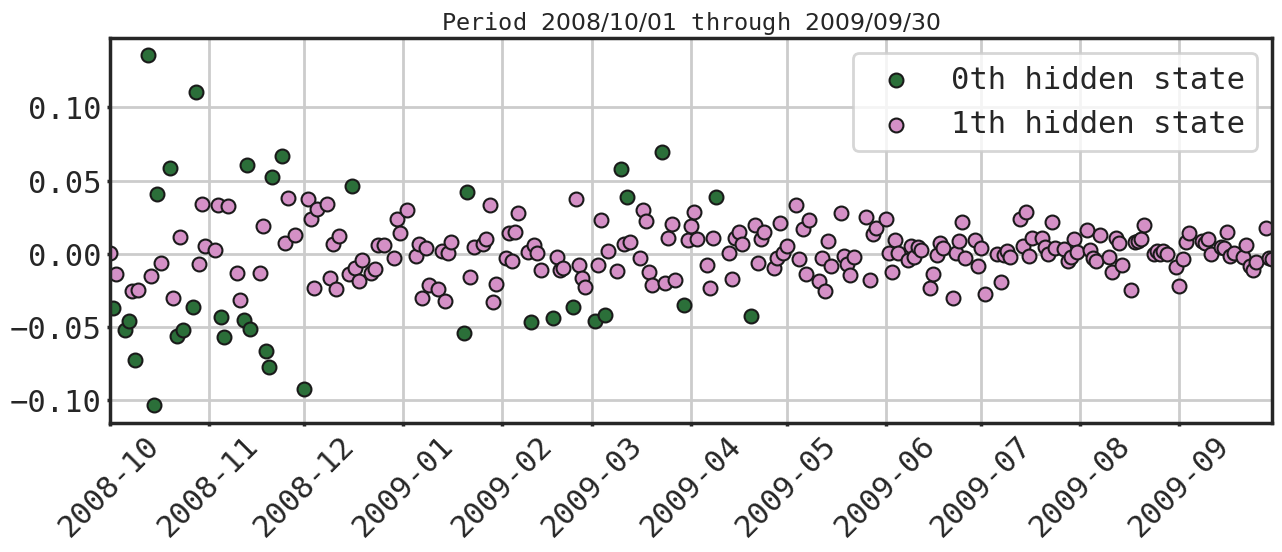

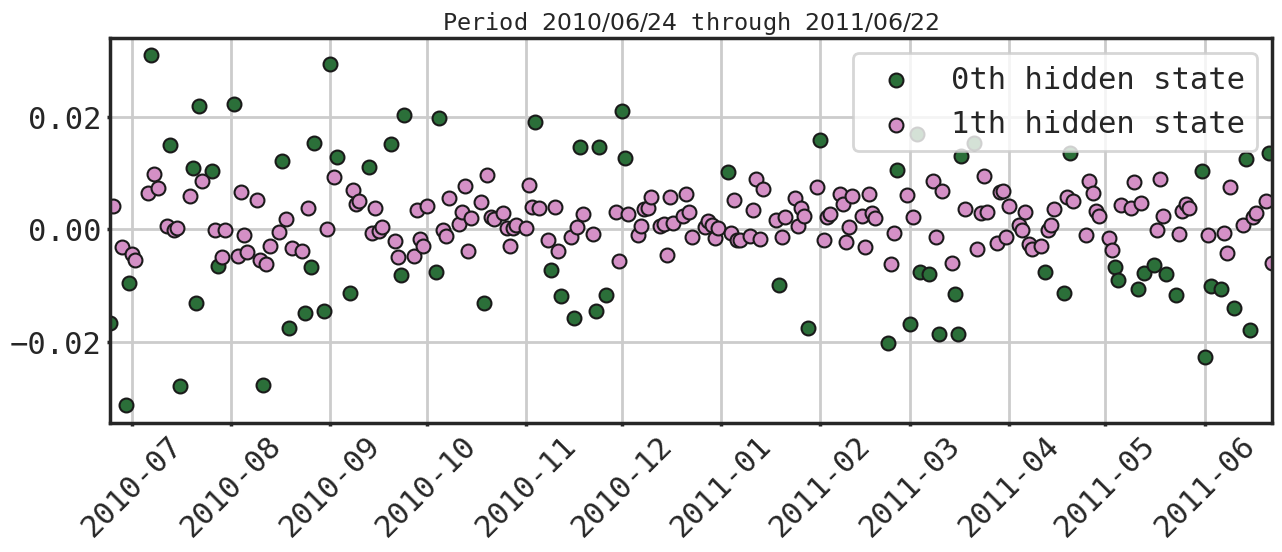

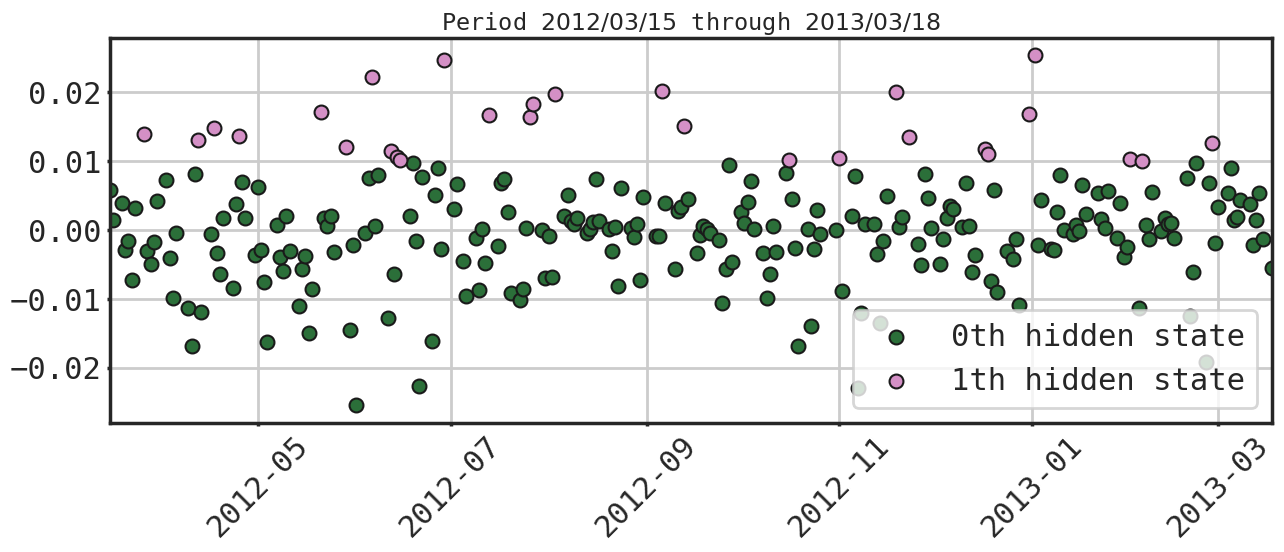

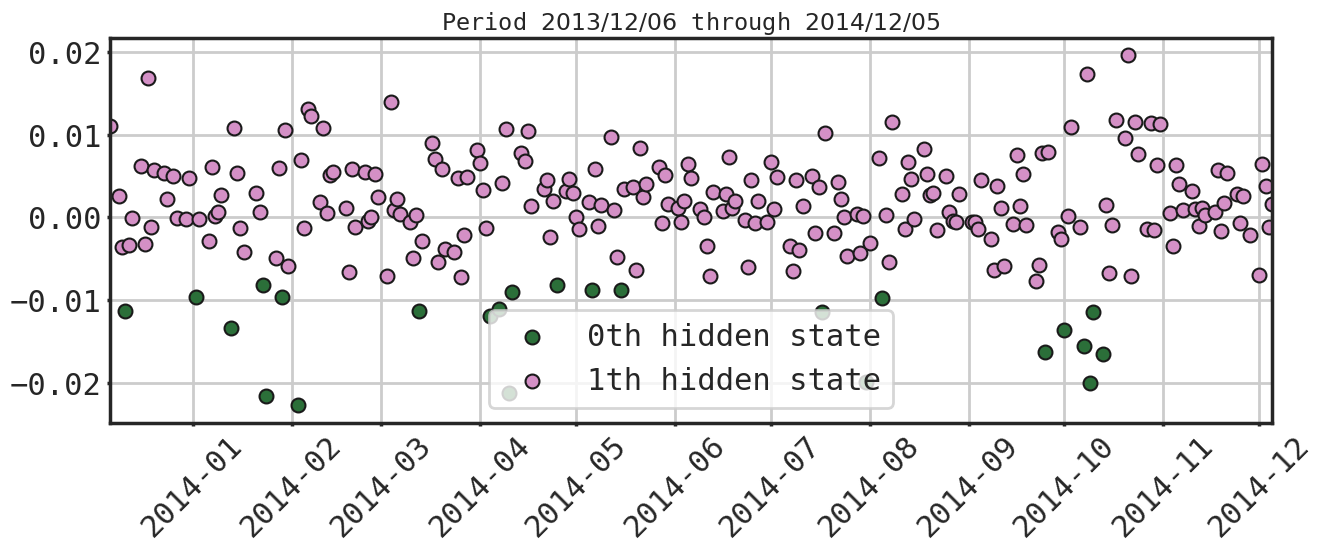

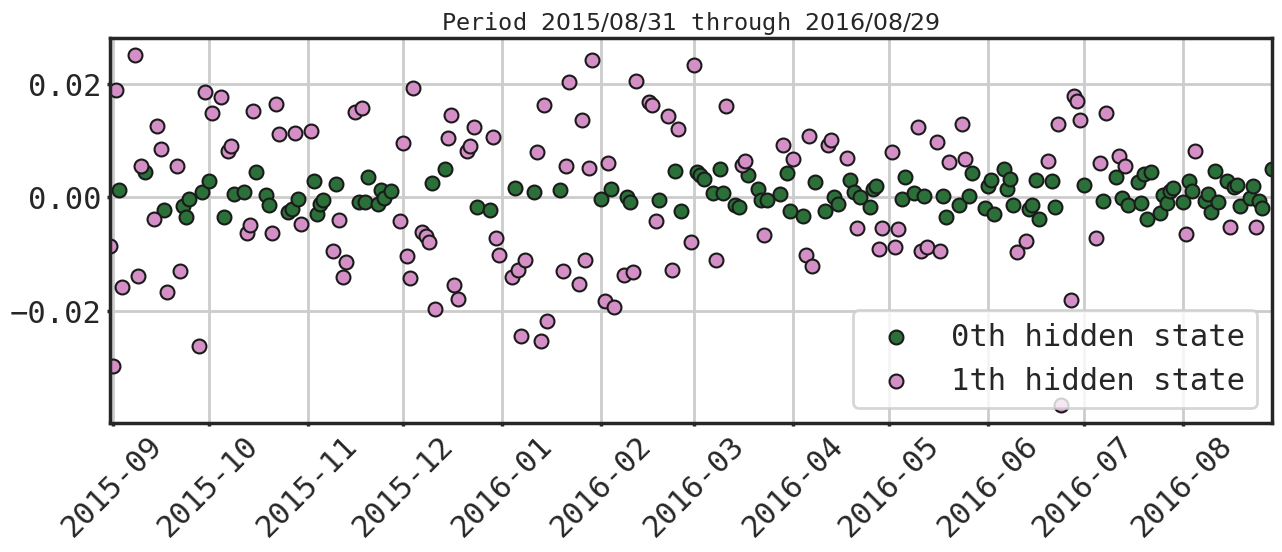

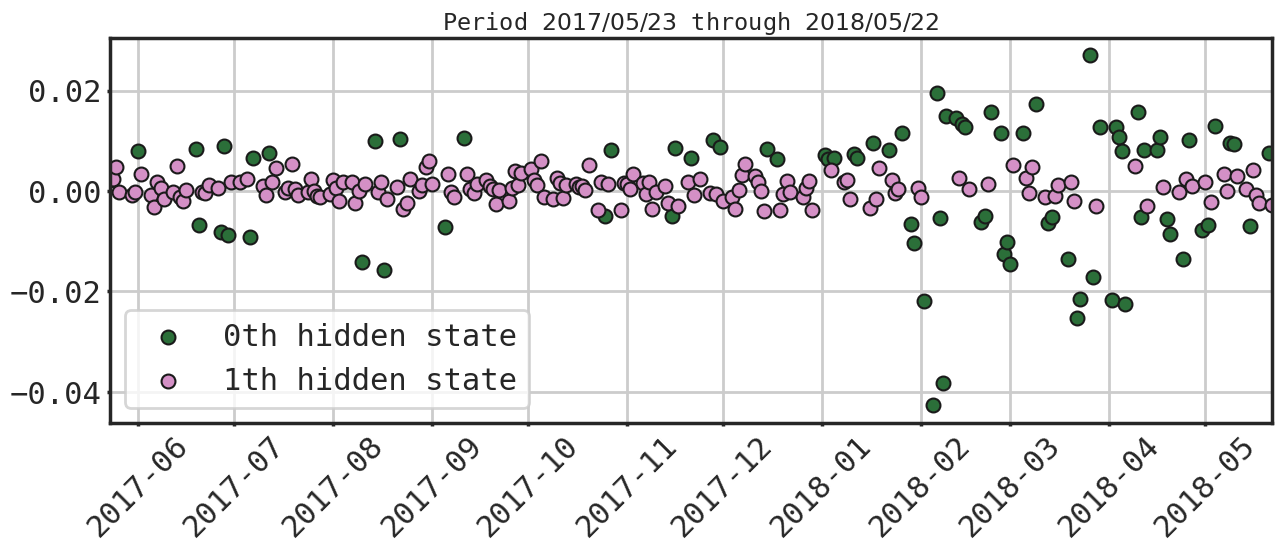

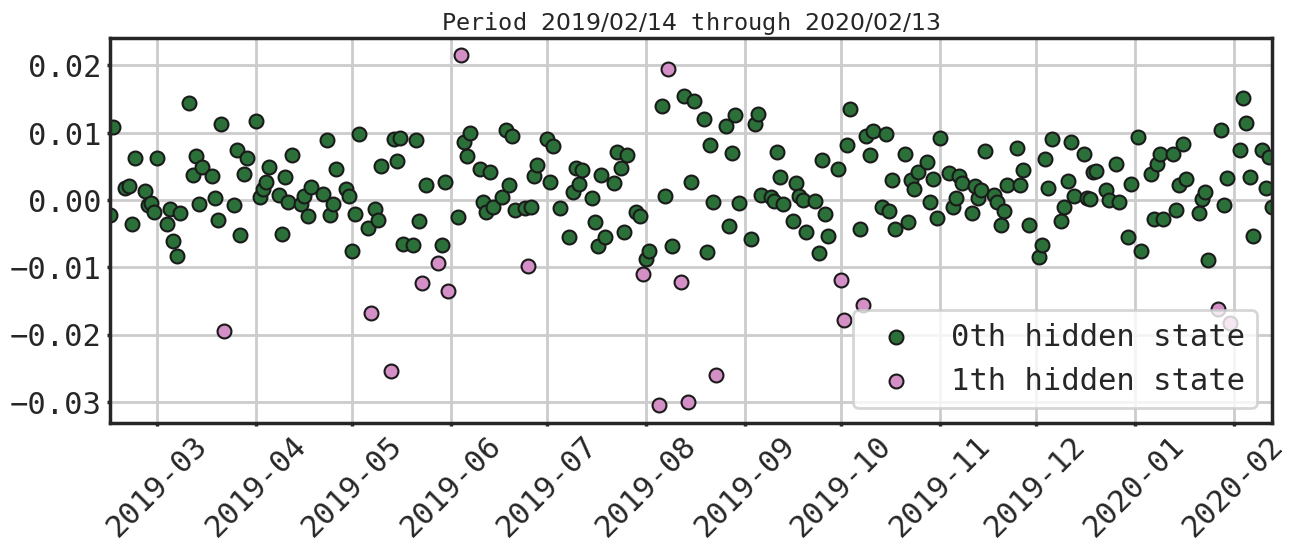

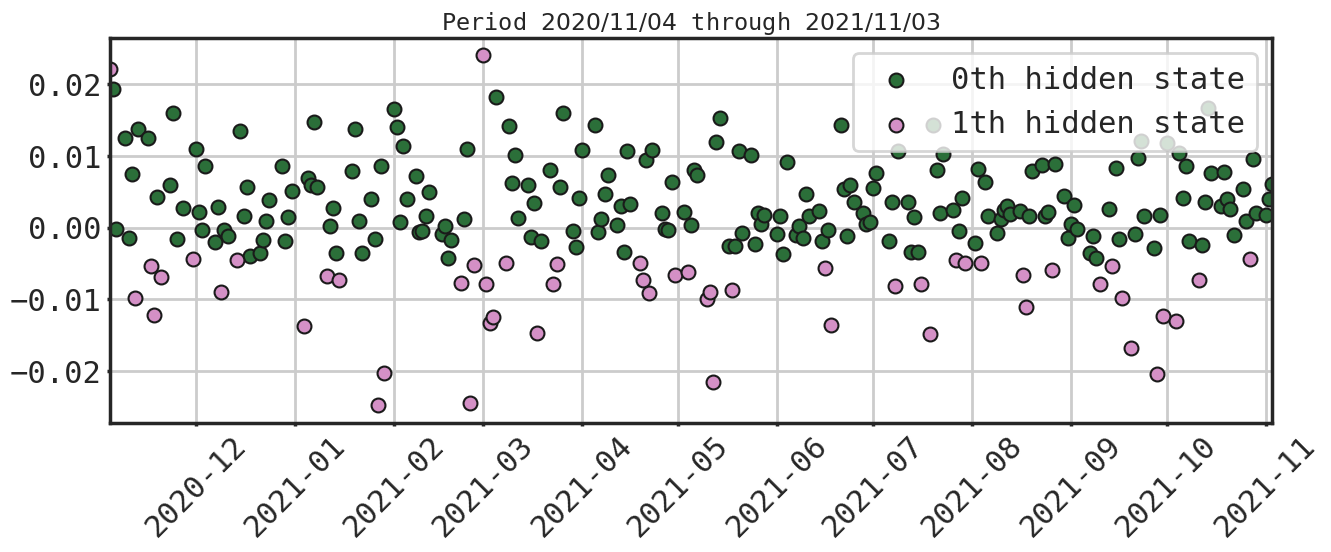

In [21]:
np.random.seed(0)

lookback = 252
n_components = 2
max_iter = 1000
n_split = n_components * 4

# stash data in lists
preds = []
pred_means = []
pred_covs = []

### begin plot code ###
fig = plt.figure(figsize=(12, 7))
colors = sns.color_palette("cubehelix", n_components) 

tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)

for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = s.iloc[train]  # temporary train data
    tmp_test = s.iloc[test]  # temporary test data

    _X = tmp_train.values.reshape(-1, 1)  # format pd.Series for sklearn
    y = tmp_train.index.values
    gmm = make_gmm(n_components, max_iter)  # make model
    gmm.fit(_X, y)  # fit model

    # predict hidden states
    hidden_states = gmm.predict(_X)

    # store output in lists
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)

    plot_results(
        tmp_train,
        gmm.predict(tmp_train.values.reshape(-1, 1)),
        gmm.means_,
        gmm.covariances_,
    )


We can see how varied the components are across different time periods. Some components are more active while others are rarely active. Additionally notice how some components are clustered over shorter sub periods while others are more evenly distributed.


#### Sampling from the GMM

What's cool about the GMM model is we can also sample directly from the posterior to generate new samples. Using the last training values from the visual example above we can see how to sample below.

The `X_s` variable is a numpy array containing the value estimates while the `y_s` contain the component labels.

In [22]:
X_s, y_s = gmm.sample(n_samples=len(tmp_train))

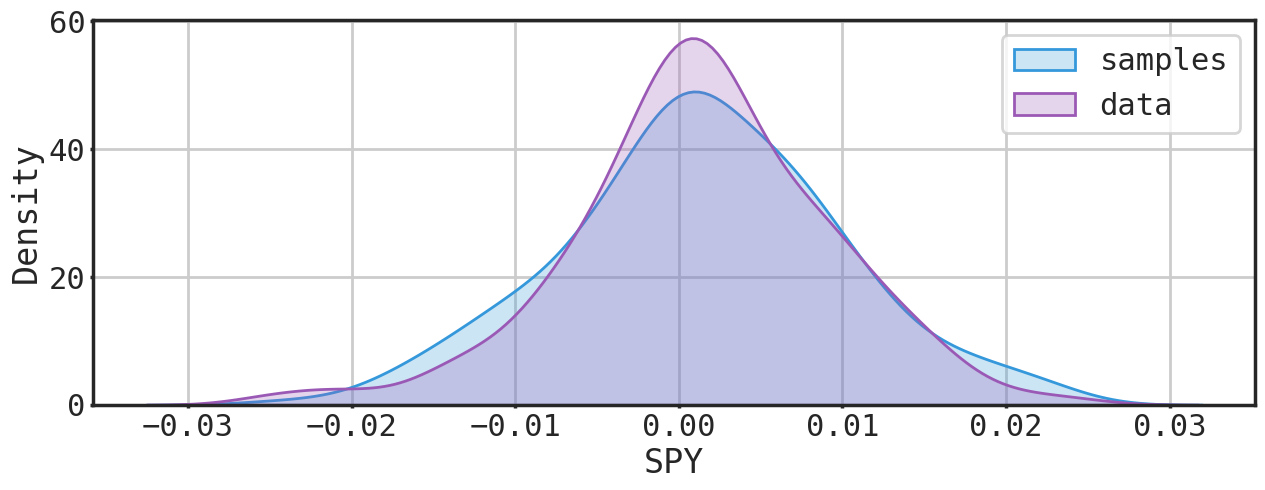

In [23]:
plt.figure()
sns.distplot(
    pd.Series(X_s.ravel()),
    ax=plt.gca(),
    label="samples",
    hist=False,
    kde_kws=dict(shade=True),
)
sns.distplot(
    pd.Series(tmp_train),
    ax=plt.gca(),
    label="data",
    hist=False,
    kde_kws=dict(shade=True),
)
plt.legend()

Next we visualize these relationships further. For each time period, we show a boxplot color coded to represent the different components.  of the aggregate returns over the period. Finally we print out the statistical description of the dataframe using `pandas.describe()`.  

#### Plot convenience functions

In [24]:
def plot_states_boxplot(states, state_col, y_col):
    g = (
        pn.ggplot(states, pn.aes(x=state_col, y=y_col, color=f"factor({state_col})"))
        + pn.geom_boxplot()
        + pn.geom_jitter(alpha=0.5)
        + pn.geom_hline(yintercept=0.0, size=1, linetype=":", color="red")
        + pn.scale_y_continuous(
            breaks=mzb.mpl_breaks(),
            labels=mzf.percent_format(),
            limits=(states[y_col].min(), states[y_col].max()),
        )
        + pn.theme_linedraw()
        + pn.theme(
            panel_background=pn.element_rect(fill="black"),
            axis_text_x=pn.element_text(rotation=30),
        )
        + pn.ylab("log returns")
        + pn.ggtitle("Log Returns by Hidden State")
    )
    return g

### Visualizing the train test split regimes

With the plotting functions defined we can loop through the `TimeseriesSplit` object to generate the plots and descriptive tables for each lookback/training period. 


*****************************************************************************


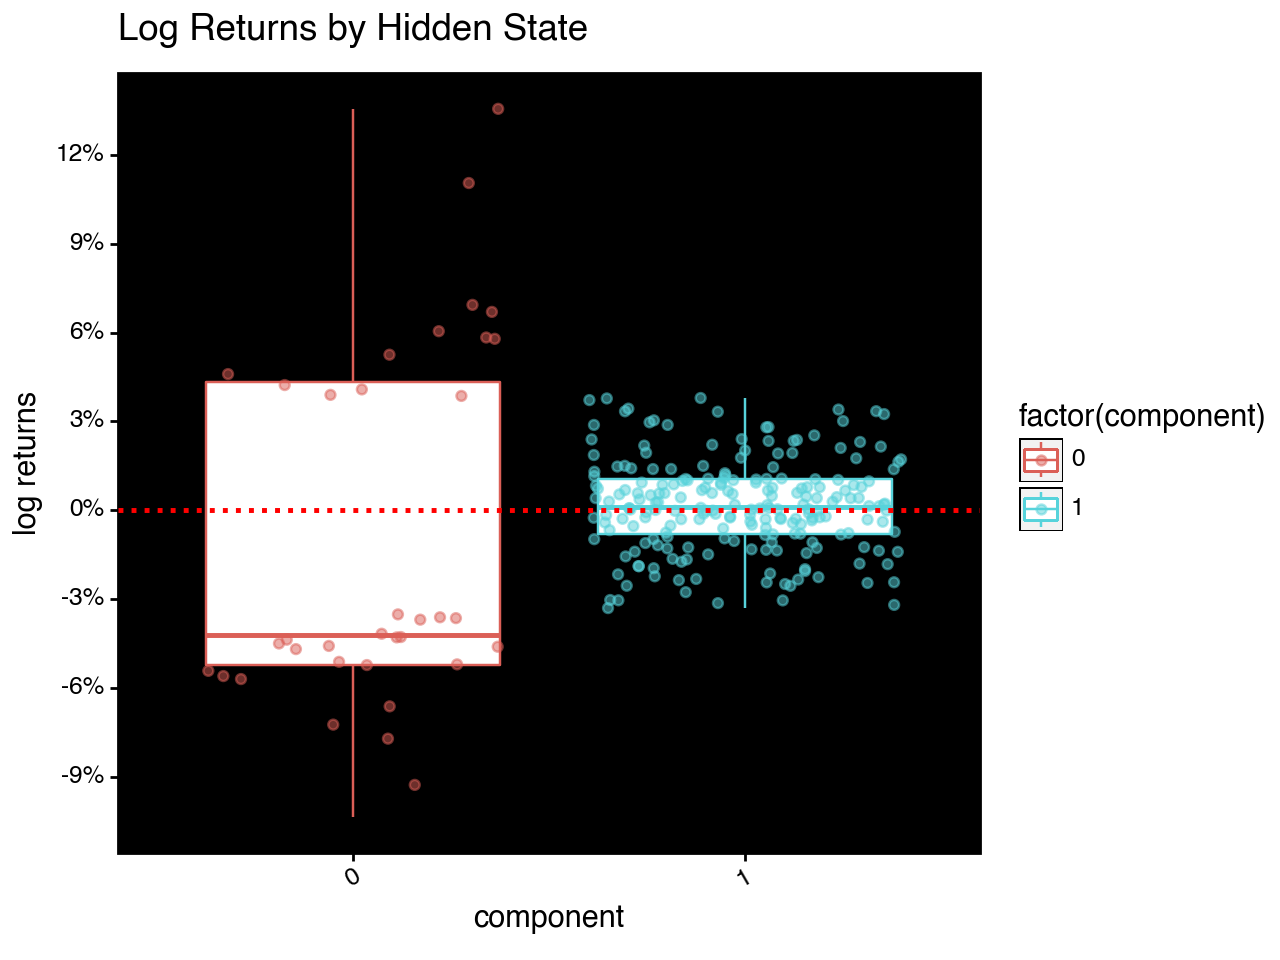

component,0,1
count,36.0000,216.0000
mean,-0.0116,0.0016
std,0.0610,0.0156
min,-0.1036,-0.0330
25%,-0.0521,-0.0081
50%,-0.0423,0.0011
75%,0.0432,0.0104
max,0.1356,0.0379



*****************************************************************************


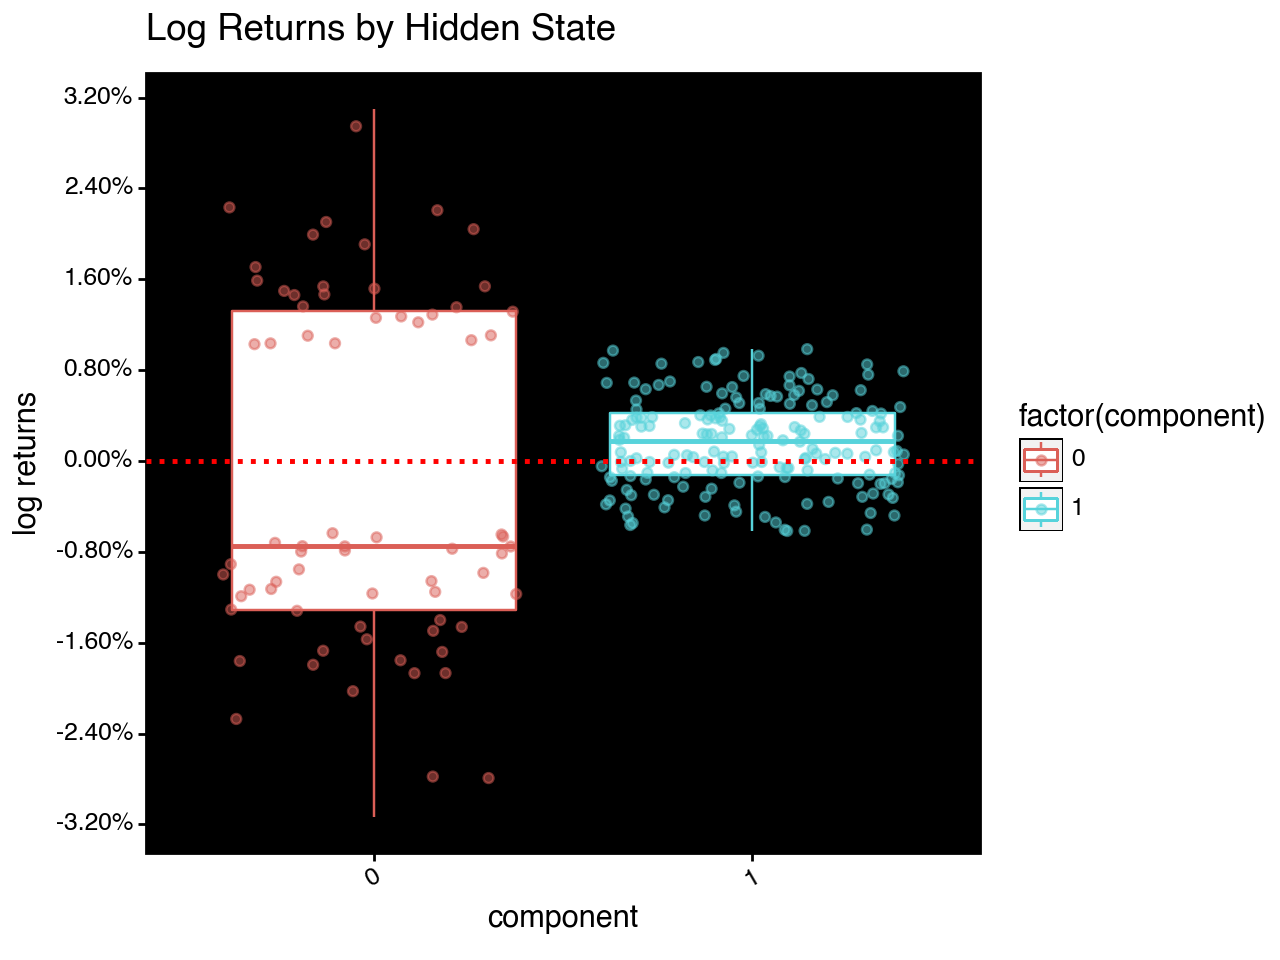

component,0,1
count,72.0000,180.0000
mean,-0.0015,0.0016
std,0.0156,0.0039
min,-0.0314,-0.0062
25%,-0.0131,-0.0013
50%,-0.0075,0.0018
75%,0.0132,0.0043
max,0.0310,0.0098



*****************************************************************************


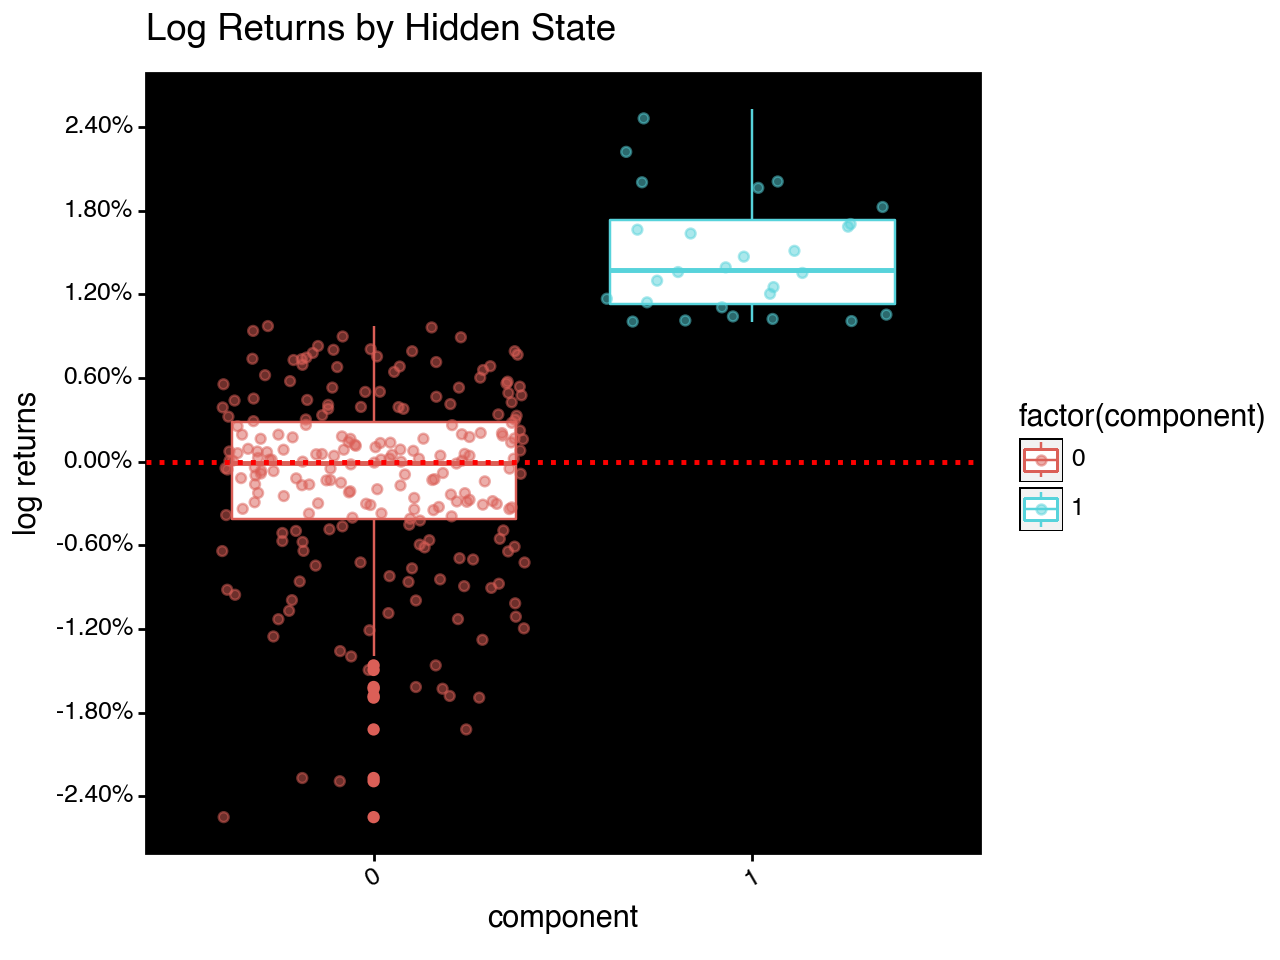

component,0,1
count,224.0000,28.0000
mean,-0.0013,0.0150
std,0.0064,0.0045
min,-0.0255,0.0100
25%,-0.0041,0.0113
50%,-0.0001,0.0138
75%,0.0028,0.0173
max,0.0097,0.0253



*****************************************************************************


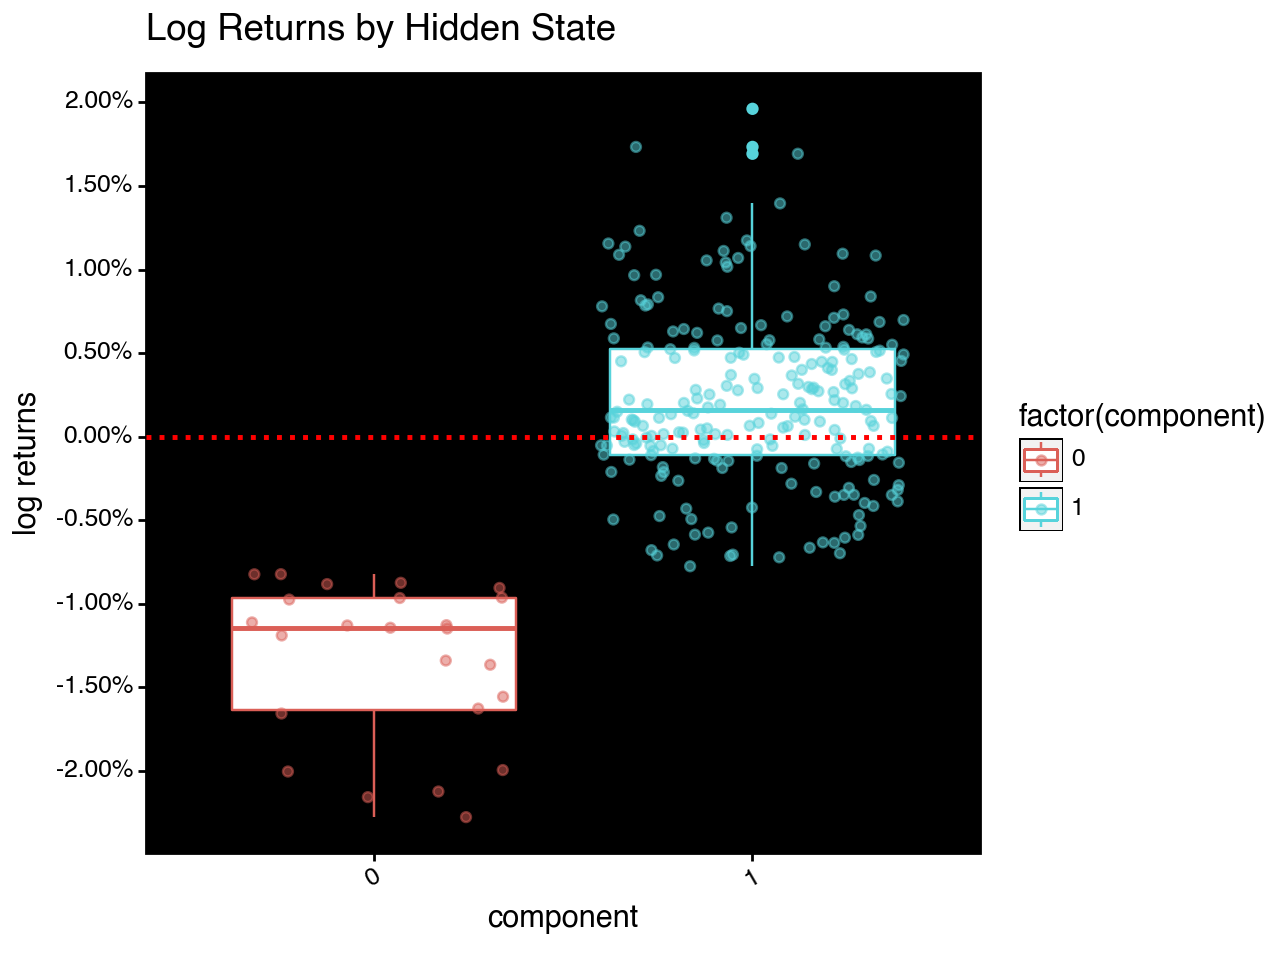

component,0,1
count,24.0000,228.0000
mean,-0.0134,0.0022
std,0.0047,0.0050
min,-0.0228,-0.0078
25%,-0.0163,-0.0011
50%,-0.0115,0.0016
75%,-0.0096,0.0053
max,-0.0082,0.0196



*****************************************************************************


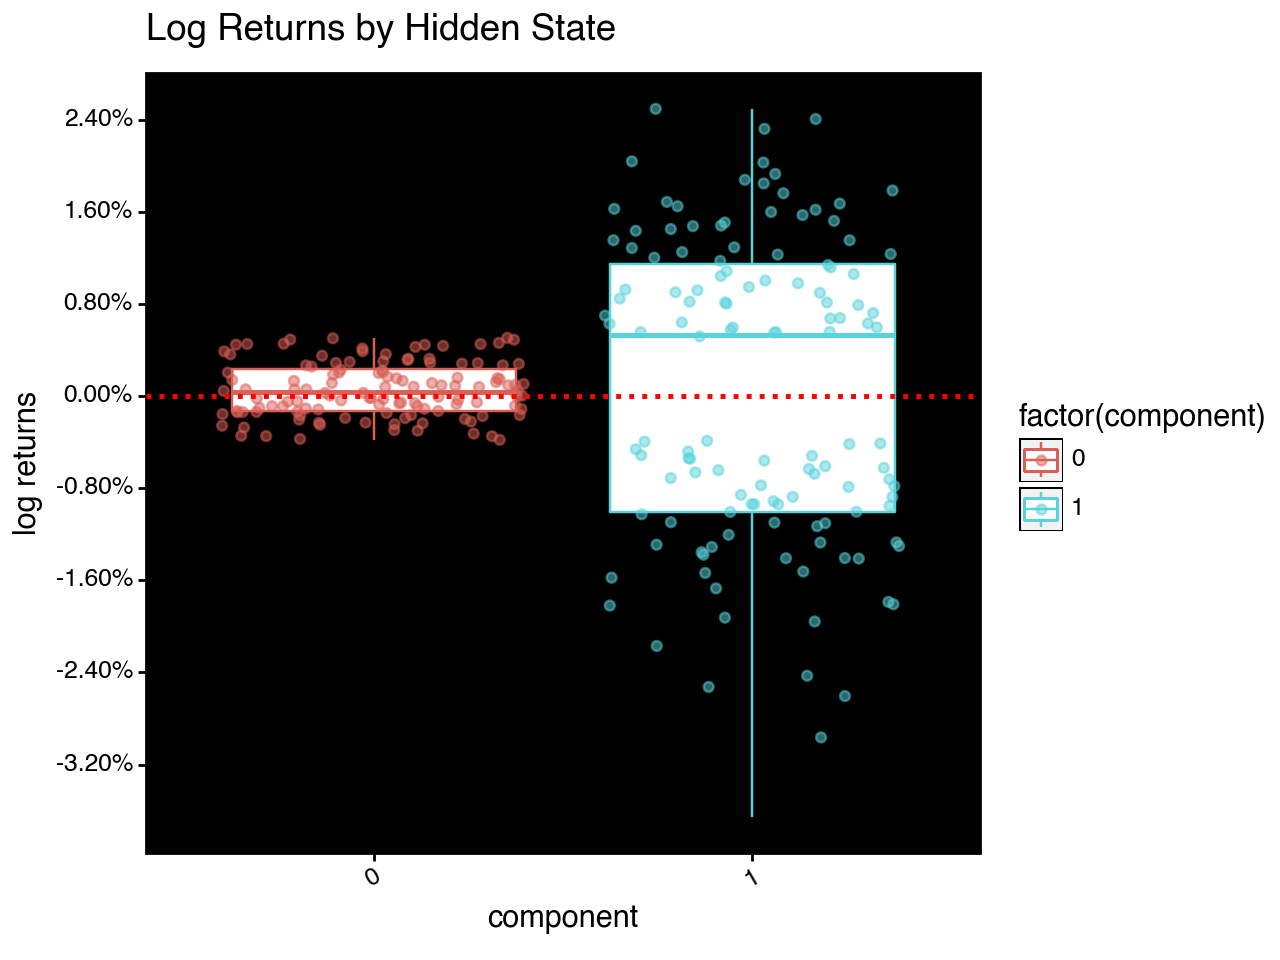

component,0,1
count,124.0000,128.0000
mean,0.0006,0.0003
std,0.0023,0.0133
min,-0.0038,-0.0366
25%,-0.0013,-0.0100
50%,0.0004,0.0054
75%,0.0024,0.0115
max,0.0051,0.0250



*****************************************************************************


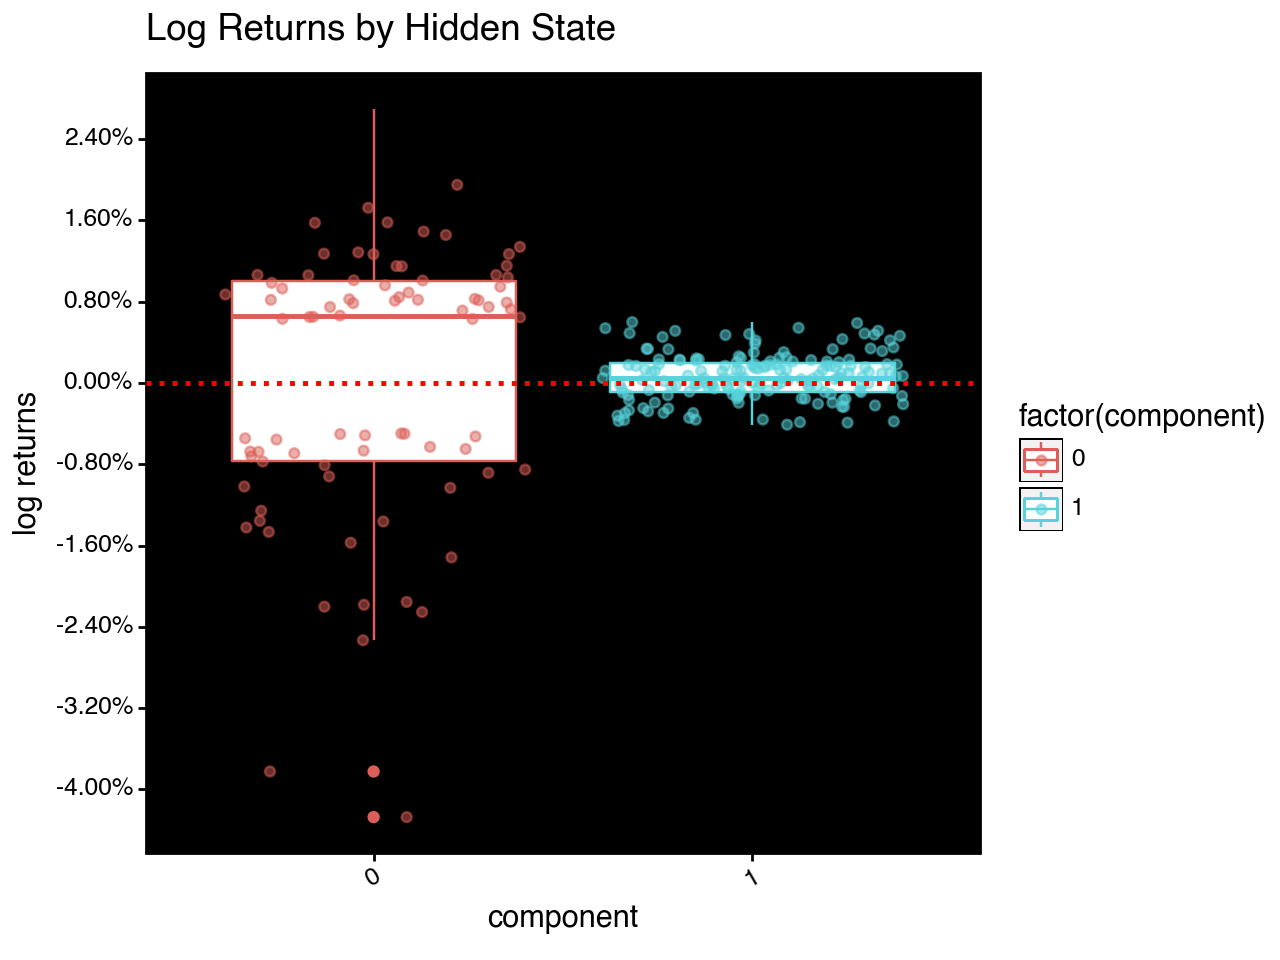

component,0,1
count,81.0000,171.0000
mean,0.0005,0.0006
std,0.0133,0.0023
min,-0.0427,-0.0041
25%,-0.0077,-0.0009
50%,0.0066,0.0005
75%,0.0101,0.0020
max,0.0270,0.0060



*****************************************************************************


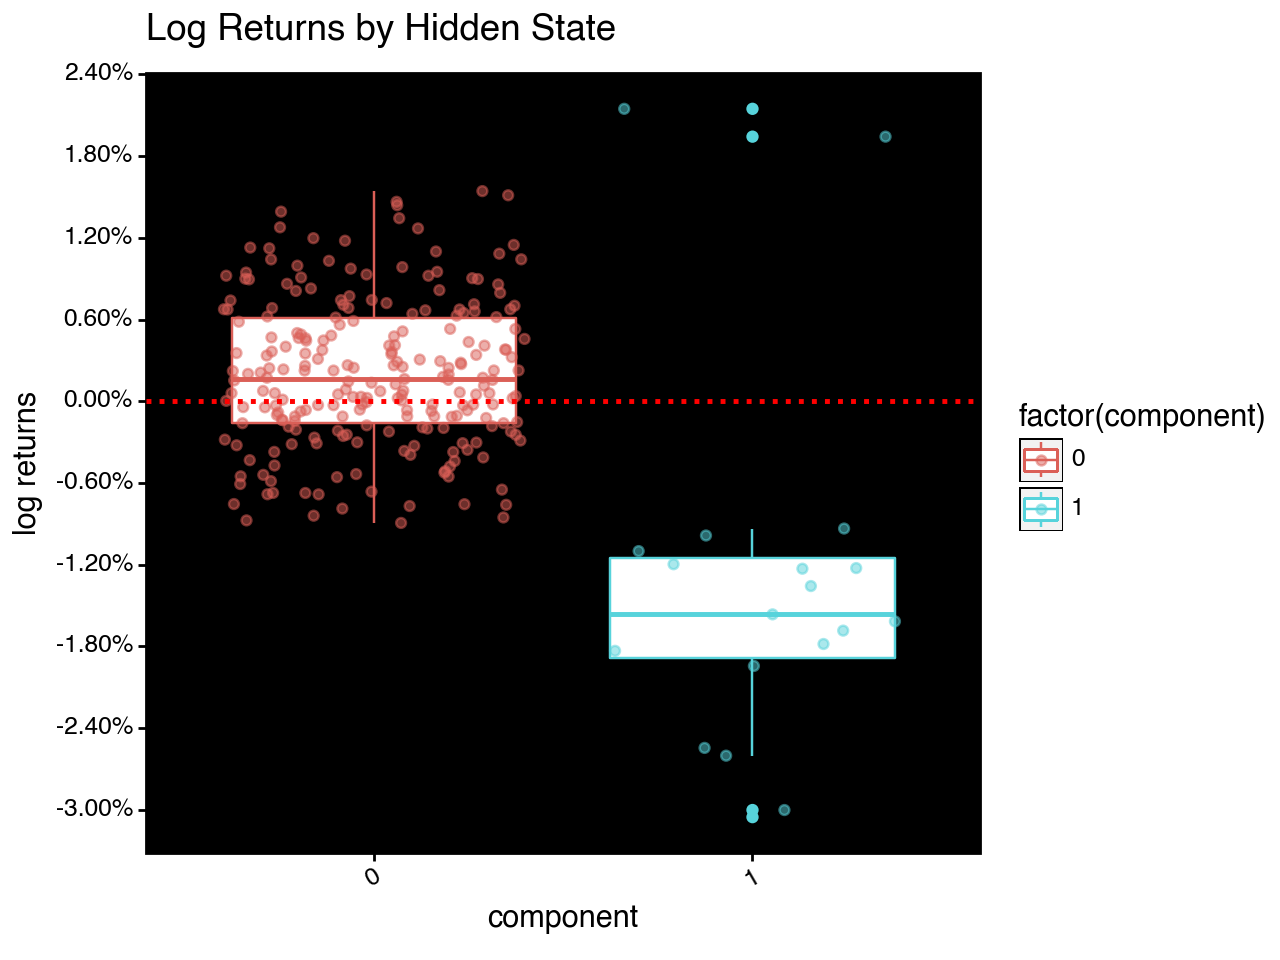

component,0,1
count,233.0000,19.0000
mean,0.0021,-0.0135
std,0.0054,0.0136
min,-0.0089,-0.0305
25%,-0.0016,-0.0189
50%,0.0016,-0.0156
75%,0.0062,-0.0115
max,0.0154,0.0215



*****************************************************************************


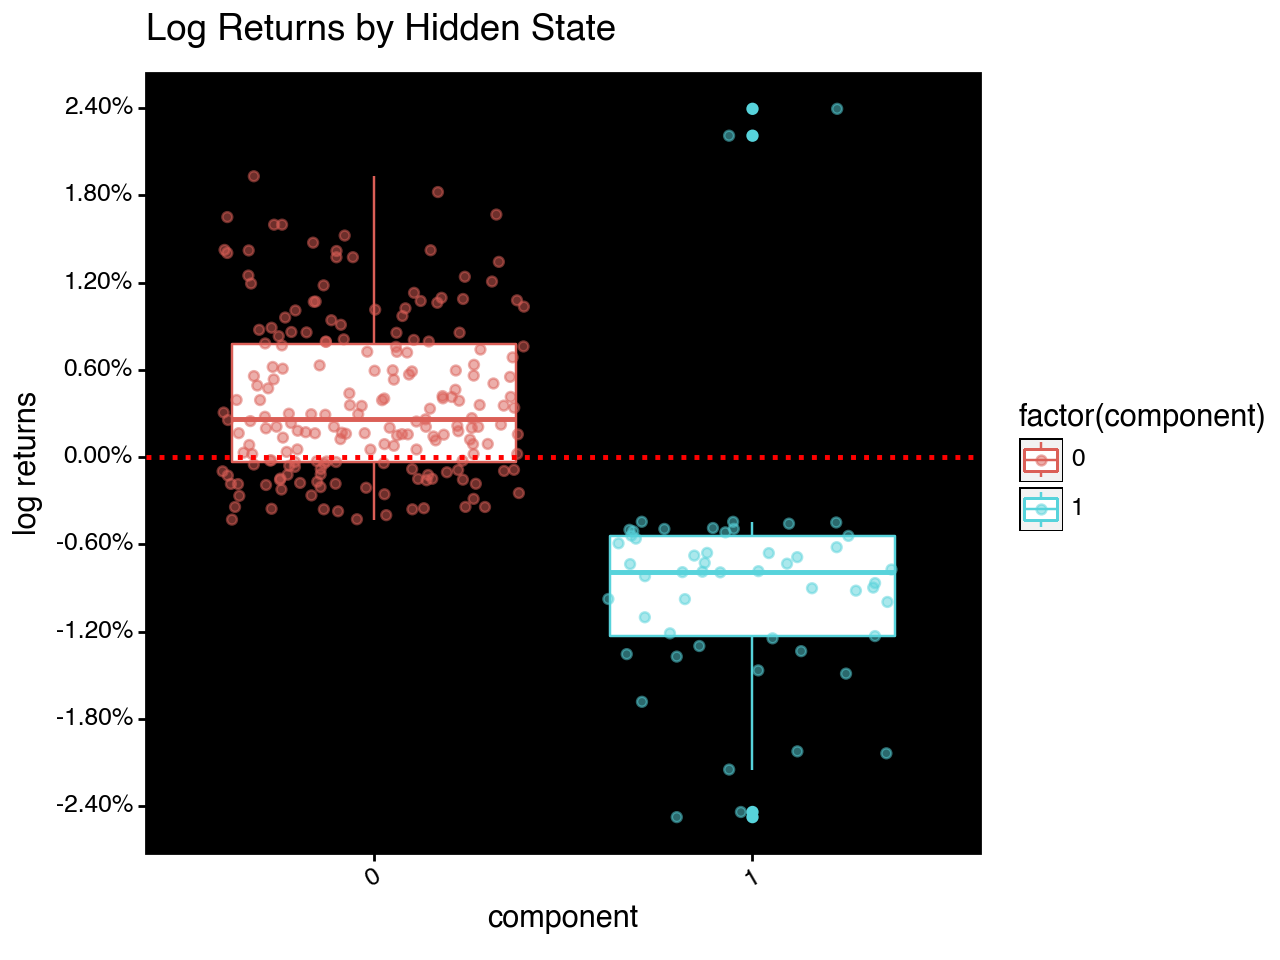

component,0,1
count,199.0000,53.0000
mean,0.0040,-0.0085
std,0.0054,0.0081
min,-0.0043,-0.0247
25%,-0.0003,-0.0123
50%,0.0026,-0.0079
75%,0.0078,-0.0054
max,0.0193,0.0240


In [25]:
### RUN` ###
for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = s.iloc[train].values.reshape(-1, 1)  # temporary train data
    tmp_test = s.iloc[test].values.reshape(-1, 1)  # temporary test data

    gmm = make_gmm(n_components, max_iter)
    gmm.fit(tmp_train, s.iloc[train].index.values)

    hidden_states_prob = gmm.predict_proba(tmp_train)
    hidden_states = gmm.predict(tmp_train)

    state_df = (
        s.iloc[train]
        .to_frame()
        .assign(component=pd.Categorical(hidden_states))
        .assign(mkt_cret=lambda df: df[sym].cumsum())
        .reset_index()
    )

    scol = "component"
    g2 = plot_states_boxplot(state_df, scol, sym)
    print()
    print("*" * 77)
    print(g2)
    display(state_df.groupby(scol)[sym].describe().T)

## Conclusions

In this notebook we covered the intuition behind Gaussian Mixture Models (GMM) and how they work. We peeled back the curtain and went through a demonstration of the underlying Expectation-Maximization algorithm that underpins GMMs and many other unsupervised algorithms. From there we used `sklearn` to fit a GMM, and how to make a good choice about the optimal number of components to fit. Finally we demonstrated some of the flexibility and variability of GMMs to fit time-varying distributions.
